In [1]:
from maps.screens import ImageScreen
import json

# Set path to parameter file
param_file = "/home/kkumbier/als/scripts/maps/template_analyses/params/maps.json"

PALETTE = {
    "WT": "#9A9A9A",
    "FUS": "#B24745" ,
    "C9orf72": "#6A6599",
    "sporadic": "#79AF97",
    "SOD1": "#00A1D5",
    "TDP43": "#DF8F44"
}

# Overview
As in the quality control example, we define an `ImageScreen` class based on a set of pre-specified parameters. These parameters reference the same dataset (see `screen` and `eval_dir`). However, there are several additional steps specified in preprocessing to modify this dataset based on our QC findings:

 - `drop_sample_by_feature` removes two cell lines we saw had unusually low counts in our QC analysis
 - `drop_cells_by_feature_qt` removes cells below the 5th or above the 95th percentiles in terms of nuclear or cell region size—a standard step we use to help screen out artifacts.
 - `select_feature_types` filters to intensity features only
 - `drop_feature_types`: removes segmentation channels
 - `pca_transform`: groups features by marker, runs PCA within each marker group, and maintains features explaining up to `alpha` percent variance
 - `subsample_rows_by_id`: takes a balanced sample of cells from each well to help mitigate training biases

This particular set of preprocessing steps is not required. E.g., you may find different (or no) cell lines with count issues in your screens and need to adjust the `drop_samples_by_feature` values. Pipelines can be built on different (or all) imaging features available. However, we note that the `subsample_rows_by_id` step is particularly important. Removing this step will result in different representations of each cell line in the training data, and subsequently, biasing towards the phenotypes of overrpresented cell lines.

On the analysis side, we define a `MAP` analysis using logistic regression with leave one out classification. `leave_one_out_mut` provides a wrapper to run this analysis over each mutational background (see `fitter` documentation).

In [2]:
# Load in analysis parameters
with open(param_file) as f:
    params = json.load(f)
 
print(json.dumps(params, indent=4))

# Initialize screen class and run data processing pipeline 
screen = ImageScreen(params)

{
    "name": "maps_dmso",
    "screen": "20250216_AWALS37_Full_screen_n96",
    "root": "/awlab/projects/2024_ALS/Experiments",
    "data_file": "Objects_Population - Nuclei Selected.txt",
    "eval_dir": "Evaluation1",
    "preprocess": {
        "drop_na_features": {
            "na_prop": 0.1
        },
        "drop_sample_by_feature": {
            "drop_key": [
                {
                    "CellLines": [
                        "C9014",
                        "NS048"
                    ]
                }
            ]
        },
        "select_sample_by_feature": {
            "select_key": [
                {
                    "Drugs": [
                        "DMSO"
                    ]
                }
            ]
        },
        "drop_cells_by_feature_qt": {
            "feature_filters": {
                "Nucleus_Region_Area_[\u00b5m\u00b2]": 0.05,
                "Cell_Region_Area_[\u00b5m\u00b2]": 0.05
            }
        },
        "select_featu

The `ImageScreen` class provides a function to scan data associated with the screen and list out all available markersets. This can be useful to write scripts that programatically iterate over markers without specifying them manually. For the purposes of demonstration, we select a single marker from this list, load the associated data, and run the preprocessing steps specified in `params`.

In [3]:
print(screen.loader.list_antibodies())
screen.load(antibody="COX IV/Galectin3/atubulin")
screen.preprocess()

shape: (9,)
Series: 'Antibody' [str]
[
	"Rab1/CHMP2B"
	"pTDP43/HMOX1"
	"p62/LC3"
	"FUS/EEA1"
	"HSP70/SOD1"
	"TDP43_abcam/G3BP1"
	"CD63/SEC16A"
	"LAMP/TDP43-C"
	"COX IV/Galectin3/atubulin"
]


As specified by the preprocessing pipeline, the data have been transformed to PCA-based features for each non-segmentation marker. Note that harmony computes "Spot" intensity features which are not associated with a specific imaging channel, which explain PC features that are not associated with a marker ID.

In [4]:
screen.data.head()

488_PC0,488_PC1,488_PC2,488_PC3,488_PC4,488_PC5,488_PC6,488_PC7,488_PC8,488_PC9,488_PC10,488_PC11,488_PC12,488_PC13,488_PC14,647_PC0,647_PC1,647_PC2,647_PC3,647_PC4,647_PC5,647_PC6,647_PC7,647_PC8,647_PC9,647_PC10,647_PC11,PC0,PC1,ID
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str
2.085063,-0.282527,0.39618,-0.428343,0.222789,0.551696,-0.179055,-0.129132,0.140663,0.990063,1.113106,0.073439,0.838494,-0.38473,-0.323667,-2.33566,-0.942972,-0.547391,0.320177,0.529653,-1.138808,-0.39642,0.173859,-0.852583,-0.805782,-0.209556,0.473029,0.232323,0.571824,"""2024042026-1-10"""
2.621025,-0.799496,0.020681,-1.653525,1.732782,-0.073415,-0.000426,0.38025,0.6304,0.397062,-0.180092,-0.200336,-0.01969,-0.453714,-0.129979,-2.969952,-1.147401,-0.420209,-0.157967,0.246087,1.864333,-0.278576,0.069525,-0.286666,-0.384016,-0.120804,-0.406442,0.550106,1.20836,"""2024042026-1-10"""
0.821228,1.942938,-0.302144,-1.775592,-0.480673,-0.19402,-1.083979,-0.558803,-0.772743,-0.07075,0.087632,-0.688986,0.07733,-0.083756,-0.281535,1.289466,3.239539,-2.765929,-0.675644,-0.862614,-0.129032,0.624884,-0.412999,-0.189164,-0.152001,-0.336648,-0.443839,-0.316318,0.027692,"""2024042026-1-10"""
0.660611,-0.648826,0.246546,0.56481,1.452253,0.861237,-1.441985,-0.649084,0.151932,1.125736,0.316099,-0.105057,0.861223,-0.574164,0.258631,-4.311249,-1.695489,0.348238,0.334237,0.382505,-0.95209,-1.166758,0.599812,-0.501939,-1.231158,-0.87904,0.371535,-0.050054,0.6082,"""2024042026-1-10"""
-2.392808,2.461473,0.444435,-0.544013,-1.138732,0.394574,-0.697099,0.242043,0.062944,0.914372,-0.229821,0.362966,-0.761744,0.792942,-0.209018,-4.892422,0.053795,0.081764,-0.406312,1.320733,-0.155766,1.04664,0.022069,0.279318,-0.434443,-0.292357,0.118053,-0.839693,-0.181439,"""2024042026-1-10"""


The `MAP` class is defined on a `Screen` class. When a `MAP` class is fit, it reads out analysis parameters specified by the screen (including model type and fitting strategy) and runs the corresponding analysis workflow. 

In [5]:
from maps.analyses import MAP
maps = MAP(screen)
maps.fit()

# Example results fro FUS
print(maps.fitted["FUS"]["predicted"].head())


Training SOD1...
Training TDP43...
Training FUS...
Training C9orf72...
shape: (5, 14)
┌──────────────┬──────────┬─────────┬─────┬───┬──────────────┬──────────────┬─────────────┬────────┐
│ ID           ┆ Ypred    ┆ Holdout ┆ Row ┆ … ┆ Plate_descri ┆ Antibody     ┆ Channel     ┆ NCells │
│ ---          ┆ ---      ┆ ---     ┆ --- ┆   ┆ ption        ┆ ---          ┆ ---         ┆ ---    │
│ str          ┆ f64      ┆ str     ┆ str ┆   ┆ ---          ┆ str          ┆ str         ┆ u32    │
│              ┆          ┆         ┆     ┆   ┆ str          ┆              ┆             ┆        │
╞══════════════╪══════════╪═════════╪═════╪═══╪══════════════╪══════════════╪═════════════╪════════╡
│ 2024042026-1 ┆ 0.467924 ┆ NS044   ┆ 1   ┆ … ┆ P8           ┆ COX IV/Galec ┆ 488/568/647 ┆ 901    │
│ -12          ┆          ┆         ┆     ┆   ┆              ┆ tin3/atubuli ┆             ┆        │
│              ┆          ┆         ┆     ┆   ┆              ┆ n            ┆             ┆        │
│ 202

To adjust for count effects observed in some MAP scores, we use the `adjust_map_scores` function. This function requires a size model, which estimates map scores as a function of cell count (per well). Since MAP scores are generated on the single cell level, we need to aggregate scores by well before fitting the size model.

In [6]:
maps.model.model.params


{'model': {'BinaryLogistic': {'tol': 0.05, 'solver': 'saga'}},
 'seed': 47,
 'response': 'Mutations',
 'fitter': 'leave_one_out_mut'}

In [7]:
import pandas as pd
from maps.utils import group_predicted, fit_size_model, adjust_map_scores

adjusted = {}
groups = ["CellLines", "Mutations", "Well"] 
k = "FUS"
v = maps.fitted[k]

print(v["predicted"].head())

grouped_pred = group_predicted(v["predicted"], groups, "Ypred")

counts = screen.metadata.select(["Well", "NCells"]).to_pandas()
df = pd.merge(grouped_pred, counts, on="Well") 
df.head()
#model, X = fit_size_model(df)

shape: (5, 14)
┌──────────────┬──────────┬─────────┬─────┬───┬──────────────┬──────────────┬─────────────┬────────┐
│ ID           ┆ Ypred    ┆ Holdout ┆ Row ┆ … ┆ Plate_descri ┆ Antibody     ┆ Channel     ┆ NCells │
│ ---          ┆ ---      ┆ ---     ┆ --- ┆   ┆ ption        ┆ ---          ┆ ---         ┆ ---    │
│ str          ┆ f64      ┆ str     ┆ str ┆   ┆ ---          ┆ str          ┆ str         ┆ u32    │
│              ┆          ┆         ┆     ┆   ┆ str          ┆              ┆             ┆        │
╞══════════════╪══════════╪═════════╪═════╪═══╪══════════════╪══════════════╪═════════════╪════════╡
│ 2024042026-1 ┆ 0.467924 ┆ NS044   ┆ 1   ┆ … ┆ P8           ┆ COX IV/Galec ┆ 488/568/647 ┆ 901    │
│ -12          ┆          ┆         ┆     ┆   ┆              ┆ tin3/atubuli ┆             ┆        │
│              ┆          ┆         ┆     ┆   ┆              ┆ n            ┆             ┆        │
│ 2024042026-1 ┆ 0.445378 ┆ NS044   ┆ 1   ┆ … ┆ P8           ┆ COX IV/Galec 

,CellLines,Mutations,Well,Ypred,NCells
0,GIH166,WT,K8,0.320252,1637
1,SS2032,FUS,F15,0.352117,1499
2,SS2032,FUS,E16,0.358782,1574
3,GIH166,WT,L7,0.401184,1464
4,CRL-2201,WT,G8,0.409839,1241


In [8]:
import pandas as pd
from maps.utils import group_predicted, fit_size_model, adjust_map_scores

adjusted = {}
groups = ["CellLines", "Mutations", "Well"] 

for k, v in maps.fitted.items():
    grouped_pred = group_predicted(v["predicted"], groups, "Ypred")

    counts = screen.metadata.select(["Well", "NCells"]).to_pandas()
    df = pd.merge(grouped_pred, counts, on="Well") 
    model, X = fit_size_model(df)

    adjusted[k] = adjust_map_scores(df, X, model)
    adjusted[k]["Group"] = k
    
print(adjusted["FUS"].head())

  CellLines Mutations Well     Ypred  NCells     Score Group
0    GIH166        WT   K8  0.320252    1637  0.419232   FUS
1    SS2032       FUS  F15  0.352117    1499  0.429655   FUS
2    SS2032       FUS  E16  0.358782    1574  0.447973   FUS
3    GIH166        WT   L7  0.401184    1464  0.473283   FUS
4  CRL-2201        WT   G8  0.409839    1241  0.447287   FUS


The adjusted (well-level) can be used for any downstream / posthoc analysis. Below we show examples of (i) MAP score adjustment process: MAP scores prior to count adjustment, the fitted count adjustment model, and corrected MAP scores and (ii) ....

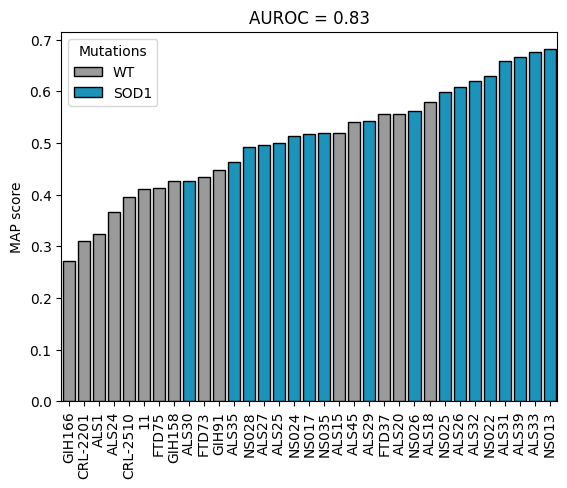

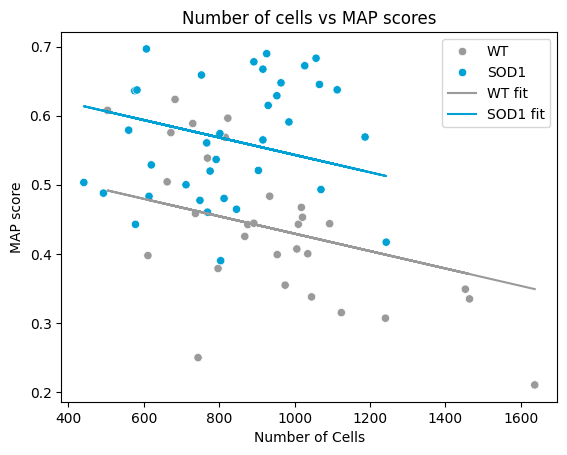

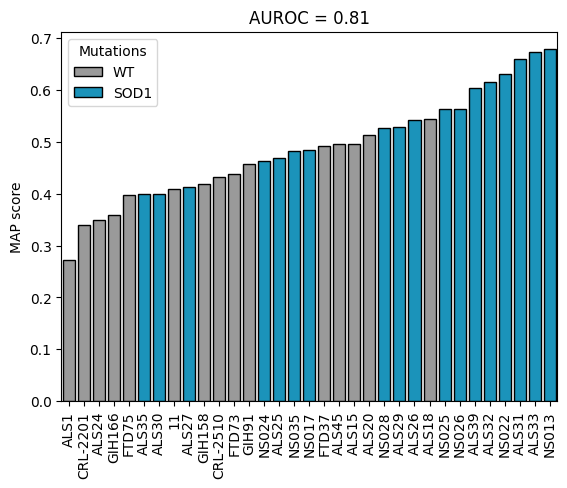

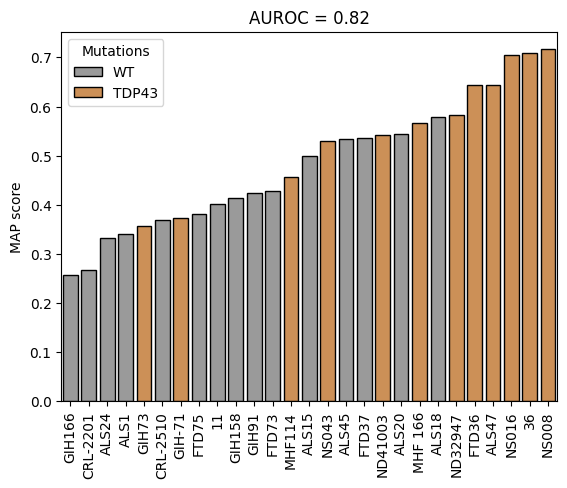

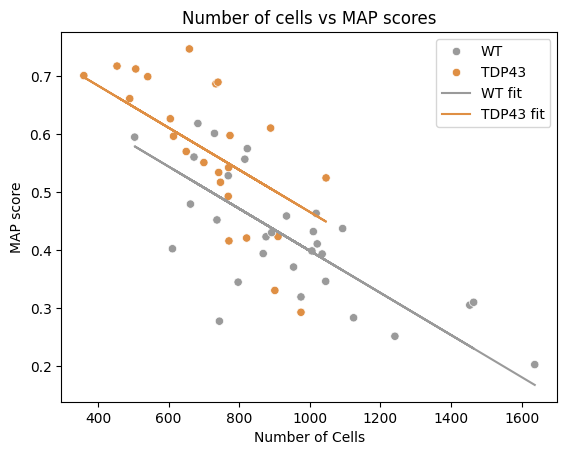

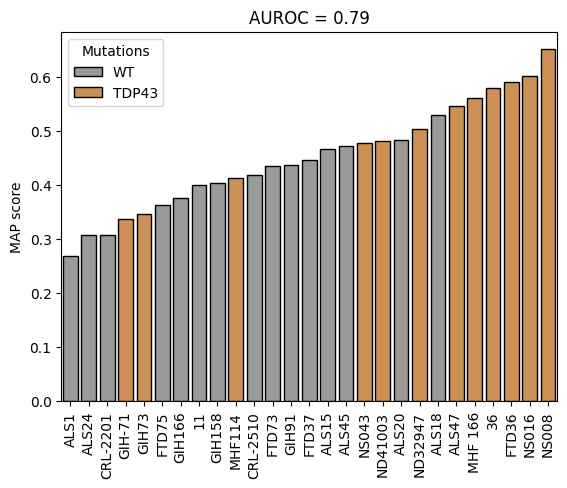

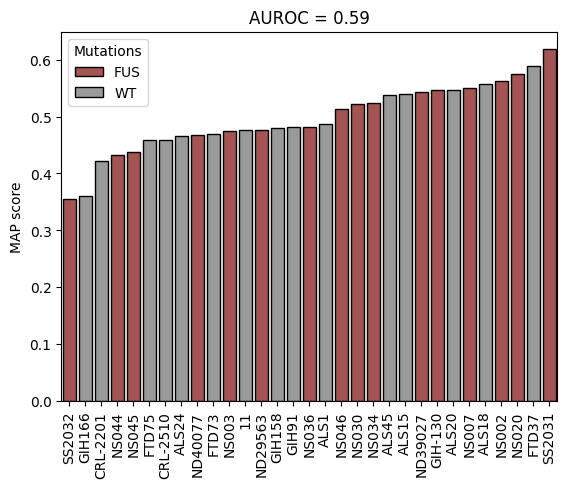

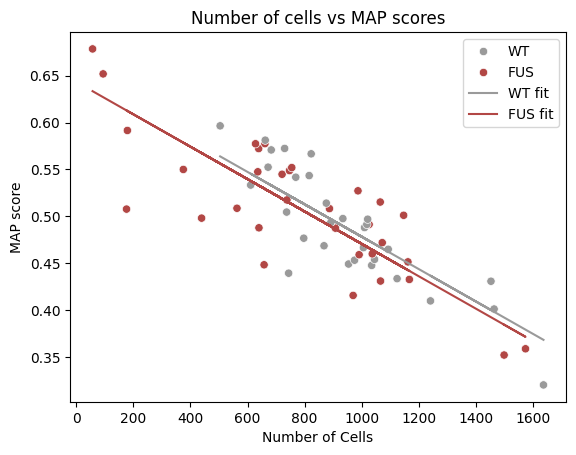

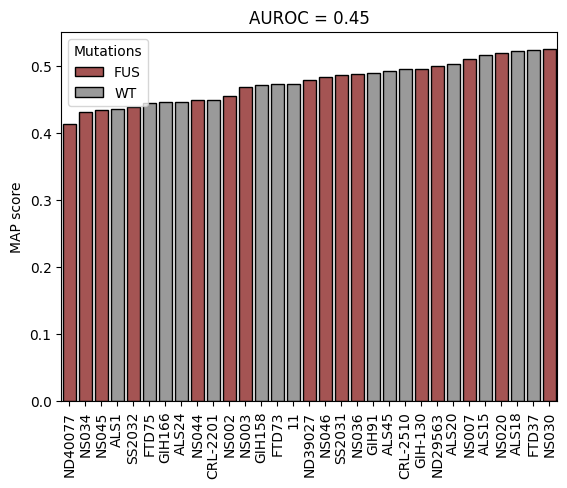

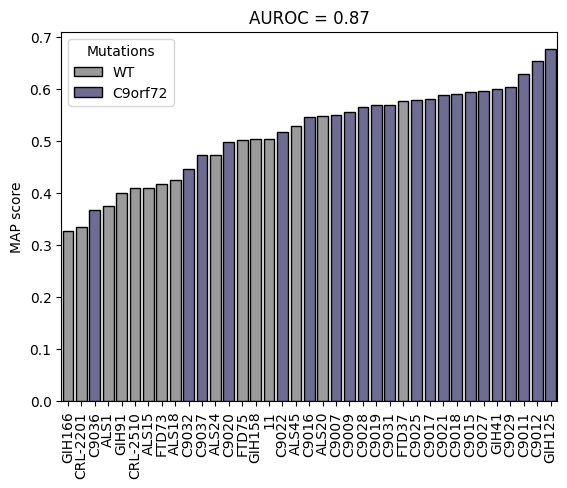

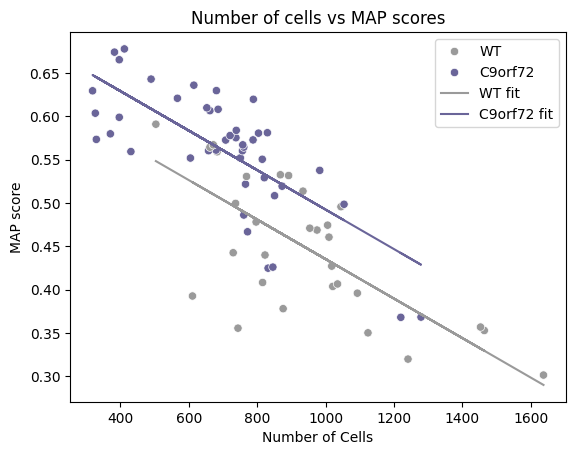

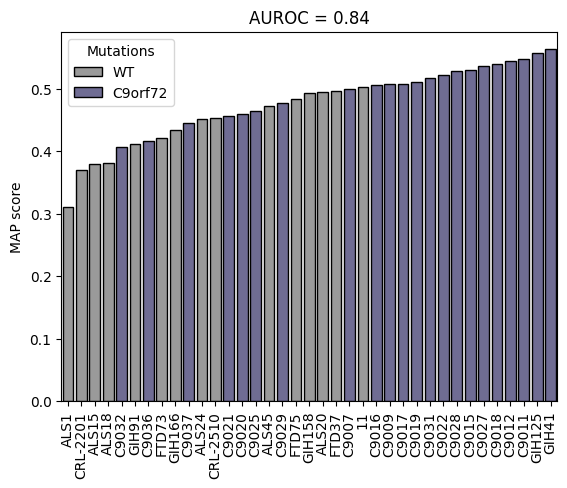

In [13]:
import polars as pl
from maps.figures import plot_grouped, plot_map_adjustment

for k, v in maps.fitted.items():
    
    raw_pred = v["predicted"] \
        .filter(pl.col("Mutations").is_in([k, "WT"]))
    
    adj_pred = pl.DataFrame(adjusted[k]) \
        .filter(pl.col("Mutations").is_in([k, "WT"]))
    
    plot_grouped(
        df=raw_pred, 
        y="Ypred",
        x="CellLines",
        hue="Mutations",
        ylab="MAP score",
        palette=PALETTE
    )
    
    # Fit size adjustment model for figure
    grouped_pred = group_predicted(raw_pred, groups, "Ypred")
    counts = screen.metadata.select(["Well", "NCells"]).to_pandas()
    df = pd.merge(grouped_pred, counts, on="Well") 
    model, X = fit_size_model(df)
    
    plot_map_adjustment(
        df=df, 
        model=model, 
        X=X, 
        sporadics=False
    )  
    
    plot_grouped(
        df=adj_pred, 
        y="Score",
        x="CellLines",
        hue="Mutations",
        ylab="MAP score",
        palette=PALETTE
    )
    
   